### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk
import os
import kagglehub

# Download resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

path = kagglehub.dataset_download("vishakhdapat/imdb-movie-reviews")

print("Path to dataset files:", path)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abamr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Path to dataset files: C:\Users\abamr\.cache\kagglehub\datasets\vishakhdapat\imdb-movie-reviews\versions\1


### Reading Dataset and doing basic analysis

In [2]:
file_path = os.path.join(path, "IMDB Dataset.csv")
df = pd.read_csv(file_path)

# Inspect the first few rows
print(df.head())
print(df['sentiment'].value_counts())


# Map sentiment to binary labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [3]:
summary = {
    'Total Rows': len(df),
    'Total Columns': len(df.columns),
    'Missing Values': df.isnull().sum().sum(),
    'Duplicate Rows': df.duplicated().sum(),
    'Unique Reviews': df['review'].nunique(),
    'Positive Count': (df['sentiment'] == 'positive').sum(),
    'Negative Count': (df['sentiment'] == 'negative').sum()
}

summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
print(summary_df)

                Value
Total Rows      50000
Total Columns       3
Missing Values      0
Duplicate Rows    418
Unique Reviews  49582
Positive Count  25000
Negative Count  25000


### Tokenzing and removing stop words

In [15]:
import re
stop_words = set(stopwords.words('english'))


# Keep negations
negations = {"not", "no", "nor", "never", "didn't", "doesn't", "isn't", "wasn't", "won't"}
stop_words = stop_words.difference(negations)

def preprocess(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    # Remove stopwords but keep negations
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [ ]:

df['cleaned_review'] = df['review'].apply(preprocess)

### Training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

### TF-IF vcectorizing (Making vocab)

In [19]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Training and testing logistic regression model

In [20]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.8951
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Trying Naive Bayes

In [21]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.8508
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Comparing

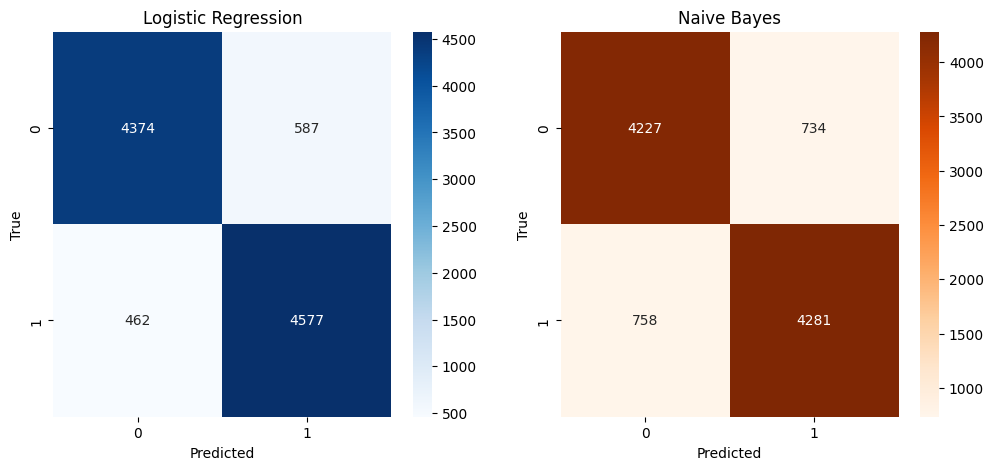

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap="Oranges", ax=axes[1])
axes[1].set_title("Naive Bayes")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000,tokenizer=preprocess)),
    ('clf', LogisticRegression(max_iter=1000))
])

# ✅ Train
lr_pipeline.fit(X_train, y_train)





c:\Users\abamr\Desktop\Python\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000,
                                 tokenizer=<function preprocess at 0x000001AA5C739BC0>)),
                ('clf', LogisticRegression(max_iter=1000))])

In [10]:
from sklearn.naive_bayes import MultinomialNB

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)



Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', MultinomialNB())])

In [18]:
import joblib

joblib.dump(lr_pipeline, "logistic_regression_pipeline.pkl")
# joblib.dump(nb_pipeline, "naive_bayes_pipeline.pkl")

['logistic_regression_pipeline.pkl']